In [70]:
from statsmodels.tsa.seasonal      import seasonal_decompose
from statsmodels.tsa.stattools     import adfuller
from statsmodels.tsa.arima.model   import ARIMA
from prophet                       import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet.plot                  import plot_cross_validation_metric
from prophet.diagnostics           import cross_validation, performance_metrics
import mlflow
# causal inference
import statsmodels.formula.api as smf
import pandas as pd
# machine learning
from sklearn.model_selection       import TimeSeriesSplit
from sklearn.linear_model          import LinearRegression

In [19]:
ptl_df = pd.read_csv(r"C:\OMDENA\Project\sao-paulo-chapter-passenger-demand\src\tasks\task_1_data_collection_preprocessing\final_datasets\alllines_ptl_complete.csv")

In [21]:
data = ptl_df
avg_data = data.groupby('year_month')['total'].mean().reset_index()

# Print the average data
avg_data

,year_month,total
0,2018-08-01,2.053300e+07
1,2018-09-01,1.866183e+07
2,2018-10-01,2.086433e+07
3,2018-11-01,1.943600e+07
4,2018-12-01,1.898467e+07
5,2019-01-01,1.802817e+07
6,2019-02-01,1.968867e+07
7,2019-03-01,2.088983e+07
8,2019-04-01,2.159450e+07
9,2019-05-01,2.238817e+07


In [22]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(avg_data['total'],autolag = 'AIC')
print(f"Adf : {dftest[0]} \nP-value : {dftest[1]}\nNo of Obv used for ADF reg and critical values : {dftest[2]}\n{dftest[4]}")

Adf : -1.8586634107788234 
P-value : 0.3517498608270538
No of Obv used for ADF reg and critical values : 0
{'1%': -3.552928203580539, '5%': -2.9147306250000002, '10%': -2.595137155612245}


p> 0.05 therefore it is not stationary 
have to do differencing 

In [65]:
avg_data['first_diff'] = avg_data['total'] - avg_data['total'].shift(1)
avg_data['first_diff']
dftest = adfuller(avg_data['first_diff'].dropna())
print(f"Adf : {dftest[0]} \nP-value : {dftest[1]}\nNo of Obv used for ADF reg and critical values : {dftest[2]}\n{dftest[4]}")

Adf : -7.045474766253053 
P-value : 5.701724734418991e-10
No of Obv used for ADF reg and critical values : 0
{'1%': -3.5552728880540942, '5%': -2.9157312396694217, '10%': -2.5956695041322315}


now p value below 0.05

<Axes: >

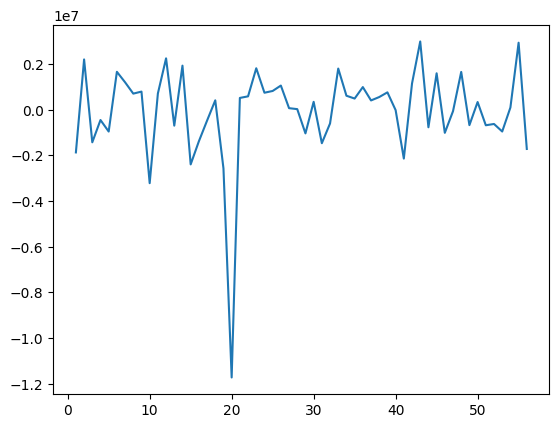

In [66]:
avg_data['first_diff'].plot()

[Text(0.5, 1.0, 'Partial Autocorrelation Function (PACF)'),
 Text(0.5, 0, 'Lag'),
 Text(0, 0.5, 'Partial Autocorrelation')]

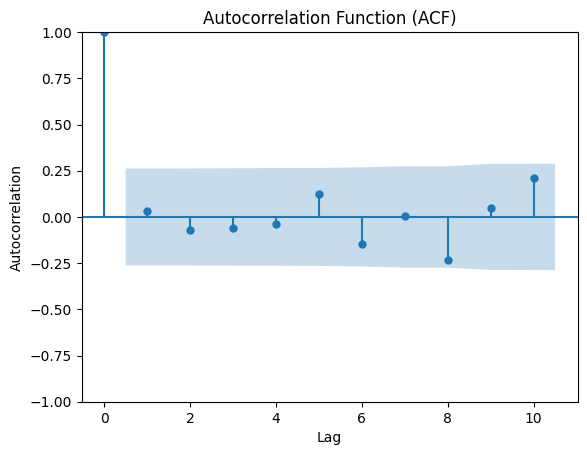

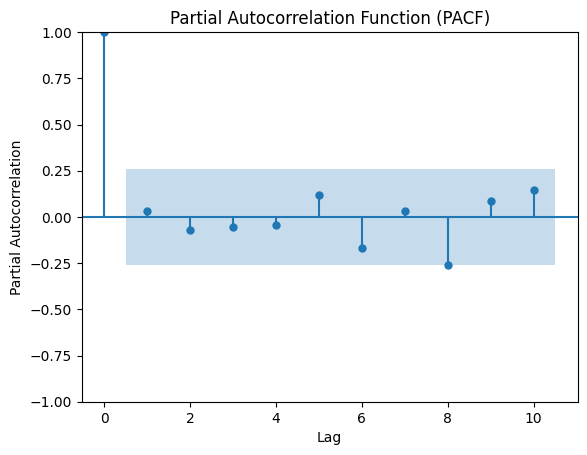

In [67]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot as plt
# Create ACF plot
acf_fig, ax = plt.subplots()
plot_acf(avg_data['first_diff'].dropna(),zero=True ,ax=ax,lags=10)

# Update the layout
ax.set(title='Autocorrelation Function (ACF)', xlabel='Lag', ylabel='Autocorrelation')

# Convert ACF plot to Plotly format
# acf_plotly = go.Figure(data=go.Scatter(x=ax.get_xticks(), y=ax.lines[0].get_ydata(), mode='lines'))

# Display the ACF plot
# acf_plotly.show()

# Create PACF plot
pacf_fig, ax = plt.subplots()
plot_pacf(avg_data['first_diff'].dropna(), ax=ax, lags=10)

# Update the layout
ax.set(title='Partial Autocorrelation Function (PACF)', xlabel='Lag', ylabel='Partial Autocorrelation')

ARIMA : auto regresive diff moving avg 

p,d,q : 

p - AR lags (pacf)
d - diff
q - MA lags (acf)

here the q is 0/1 as there is sudden drop in acf plot
and p is 1 as there is sudden drop after 1 in pacf plot 

# Training using ML flow 

In [ ]:
avg_data.set_index('year_month', inplace=True)


In [81]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
import mlflow

a =1
s = 1 
mlflow.set_tracking_uri("http://127.0.0.1:5000")
# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train_data, test_data = avg_data[:train_size], avg_data[train_size:]

# Define the parameters for the ARIMA model
order = (1, 1, 1) 

# Define the parameters for the SARIMA model
seasonal_order = (1, 1, 1, 12)  

# Initialize the Prophet model
prophet_model = Prophet()

# Define the number of splits for cross-validation
n_splits = 7

# Initialize the TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=n_splits)

# Iterate over the splits and train/test the models
for train_index, test_index in tscv.split(train_data):
    # Train/test split for ARIMA and SARIMA
    arima_train, arima_test = train_data.iloc[train_index], train_data.iloc[test_index]
    
    
    # Train/test split for Prophet
    prophet_train, prophet_test = train_data.iloc[:train_index[-1]+1], train_data.iloc[test_index]
    
    # Start an MLflow run for ARIMA
    with mlflow.start_run():
        mlflow.log_param("model", "ARIMA")
        
        # Fit the ARIMA model
        arima_model = ARIMA(arima_train["first_diff"], order=order)
        arima_model_fit = arima_model.fit()
        
        # Log the trained model
        mlflow.statsmodels.log_model(arima_model_fit, "arima_model")
        
        # Make predictions on the test set
        arima_predictions = arima_model_fit.forecast(steps=len(arima_test["first_diff"]))
        
        # Evaluate the ARIMA model
        arima_rmse = np.sqrt(mean_squared_error(arima_test["first_diff"], arima_predictions))
        
        # Log evaluation metrics
        mlflow.log_metric("rmse", arima_rmse)
        
        arima_mape = mean_absolute_percentage_error(arima_test["first_diff"], arima_predictions)
        mlflow.log_metric("mape", arima_mape)
        
        # plots 
        # Plot the results
        plt.plot(arima_test.index, arima_test.values, label="Actual")
        plt.plot(arima_test.index, arima_predictions, label="Predicted")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.title("ARIMA Model - Actual vs Predicted")
        plt.legend()

        # Save the plot
        
        plt.savefig(f"arima_plot{a}.png")
        plt.close()
        
        # Log the plot
        mlflow.log_artifact(f"arima_plot{a}.png")
        a += 1
        # End the MLflow run for ARIMA
    
    # Start an MLflow run for SARIMA
    with mlflow.start_run():
        mlflow.log_param("model", "SARIMA")
        
        # Fit the SARIMA model
        sarima_model = SARIMAX(arima_train["first_diff"], order=order, seasonal_order=seasonal_order)
        sarima_model_fit = sarima_model.fit()
        
        # Log the trained model
        mlflow.statsmodels.log_model(sarima_model_fit, "sarima_model")
        
        # Make predictions on the test set
        sarima_predictions = sarima_model_fit.forecast(steps=len(arima_test["first_diff"]))
        
        # Evaluate the SARIMA model
        sarima_rmse = np.sqrt(mean_squared_error(arima_test["first_diff"], sarima_predictions))
        
        # Log evaluation metrics
        mlflow.log_metric("rmse", sarima_rmse)
        sarima_mape = mean_absolute_percentage_error(arima_test["first_diff"], sarima_predictions)
        mlflow.log_metric("mape", sarima_mape)
        # Plot the results
        plt.plot(arima_test.index, arima_test.values, label="Actual")
        plt.plot(arima_test.index, sarima_predictions, label="Predicted")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.title("SARIMA Model - Actual vs Predicted")
        plt.legend()

        # Save the plot
        plt.savefig(f"sarima_plot{s}.png")
        plt.close()
        
        # Log the plot
        mlflow.log_artifact(f"sarima_plot{s}.png")
        s += 1
        # End the MLflow run for SARIMA
    
    # Start an MLflow run for Prophet
    # with mlflow.start_run():
    #     mlflow.log_param("model", "Prophet")
        
    #     # Fit the Prophet model
    #     prophet_model.fit(prophet_train["first_diff"])
        
    #     # Make predictions on the test set
    #     prophet_future = prophet_model.make_future_dataframe(periods=len(prophet_test["first_diff"]))
    #     prophet_predictions = prophet_model.predict(prophet_future)[-len(prophet_test["first_diff"]):]["yhat"]
        
    #     # Evaluate the Prophet model
    #     prophet_rmse = np.sqrt(mean_squared_error(prophet_test["first_diff"], prophet_predictions))
        
    #     # Log evaluation metrics
    #     mlflow.log_metric("rmse", prophet_rmse)
    #     prophet_mape = mean_absolute_percentage_error(prophet_test["first_diff"], prophet_predictions)
    #     mlflow.log_metric("mape", prophet_mape)
    #     plt.plot(prophet_test.index, prophet_test.values, label="Actual")
    #     plt.plot(prophet_test.index, prophet_predictions, label="Predicted")
    #     plt.xlabel("Time")
    #     plt.ylabel("Value")
    #     plt.title("Prophet Model - Actual vs Predicted")
    #     plt.legend()

    #     # Save the plot
    #     plt.savefig("prophet_plot.png")
    #     plt.close()

    #     # Log the plot
    #     mlflow.log_artifact("prophet_plot.png")
        # End the MLflow run for Prophet


c:\Users\shash\anaconda3\envs\legoFormer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\shash\anaconda3\envs\legoFormer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\shash\anaconda3\envs\legoFormer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\shash\anaconda3\envs\legoFormer\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\shash\anaconda3\envs\legoFormer\lib\site-packages\statsmod